# Librerías

In [ ]:
import pandas as pd
import numpy as np
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Archivo de datos

In [ ]:
df_calls = pd.read_csv('/datasets/telecom_dataset_us.csv')
df_clients = pd.read_csv('/datasets/telecom_clients_us.csv')

In [ ]:
df_calls.sample(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
4587,166511,2019-09-24 00:00:00+03:00,out,False,891410.0,False,28,5949,6198
22537,167060,2019-11-21 00:00:00+03:00,in,False,930908.0,False,1,6,12
32861,167475,2019-11-21 00:00:00+03:00,in,False,NaN,True,1,0,26
46891,168154,2019-11-05 00:00:00+03:00,in,False,939370.0,False,15,1558,1873
12335,166725,2019-10-05 00:00:00+03:00,in,False,NaN,True,11,0,241


In [ ]:
df_clients.sample(5)

,user_id,tariff_plan,date_start
348,166918,C,2019-08-23
82,167212,C,2019-09-06
238,167906,C,2019-10-04
118,168471,C,2019-10-28
16,168253,A,2019-10-18


In [ ]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [ ]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


# Análisis Exploratorio de Datos

In [ ]:
df_calls['date'] = pd.to_datetime(df_calls['date'])
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])

## Datos duplicados

In [ ]:
df_calls.duplicated().sum()

np.int64(4900)

In [ ]:
df_clients.duplicated().sum()

np.int64(0)

In [ ]:
df_calls = df_calls.drop_duplicates()
df_calls.duplicated().sum()

np.int64(0)

## Datos ausentes

In [ ]:
df_calls.isna().sum()

,0
user_id,0
date,0
direction,0
internal,110
operator_id,7456
is_missed_call,0
calls_count,0
call_duration,0
total_call_duration,0


In [ ]:
df_calls = df_calls.dropna(subset=['operator_id'])
df_calls = df_calls.dropna(subset=['internal'])

In [ ]:
df_calls['operator_id'] = df_calls['operator_id'].astype(int)

## Valores atípicos

In [ ]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]

df_calls = remove_outliers_iqr(df_calls, 'call_duration')
df_calls = remove_outliers_iqr(df_calls, 'total_call_duration')
df_calls = remove_outliers_iqr(df_calls, 'calls_count')

El dataframe de los operadores, tenía algunos datos duplicados y ausentes de los cuales me deshice.

Además me encargué de eliminar los valores atípicos de las columnas más importantes para evitar sesgos en el análisis.

# Porcentaje de llamadas perdidas

In [ ]:
missed_call_rate = df_calls['is_missed_call'].mean() * 100
missed_call_rate

np.float64(35.856978842053465)

# Duración de llamadas

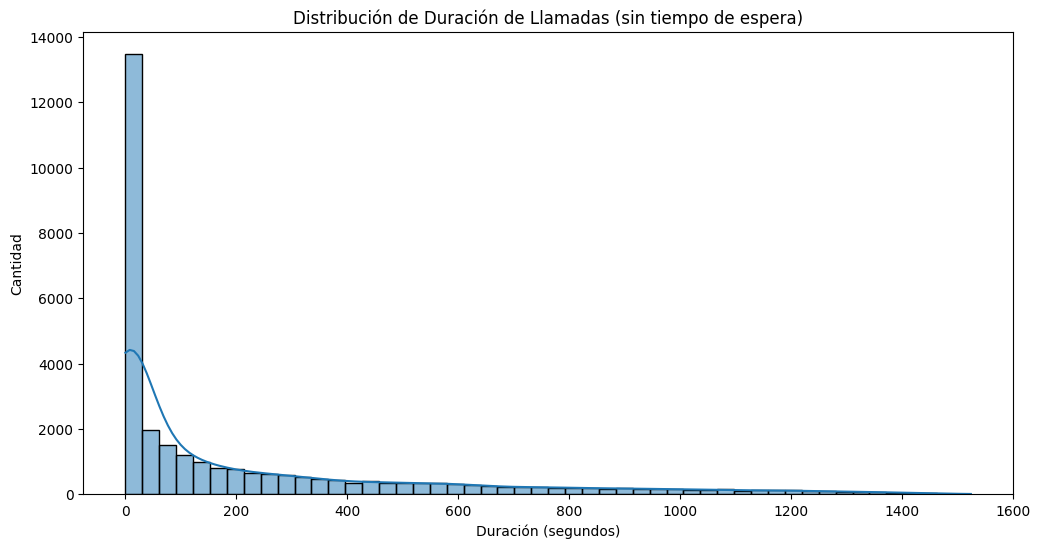

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(df_calls['call_duration'], bins=50, kde=True)
plt.title('Distribución de Duración de Llamadas (sin tiempo de espera)')
plt.xlabel('Duración (segundos)')
plt.ylabel('Cantidad')
plt.show()

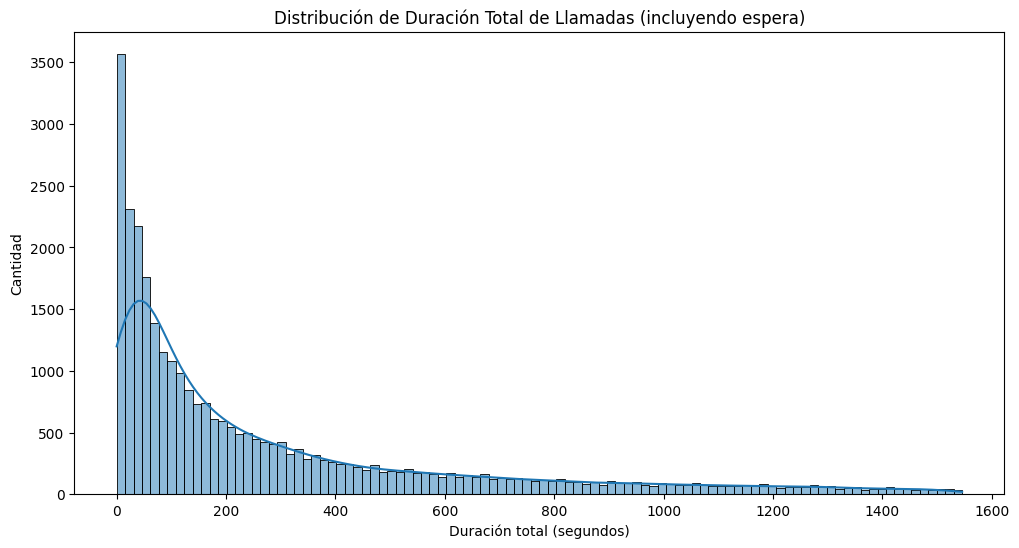

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(df_calls['total_call_duration'], bins=100, kde=True)
plt.title('Distribución de Duración Total de Llamadas (incluyendo espera)')
plt.xlabel('Duración total (segundos)')
plt.ylabel('Cantidad')
plt.show()

# Tipos de llamadas: entrantes/salientes

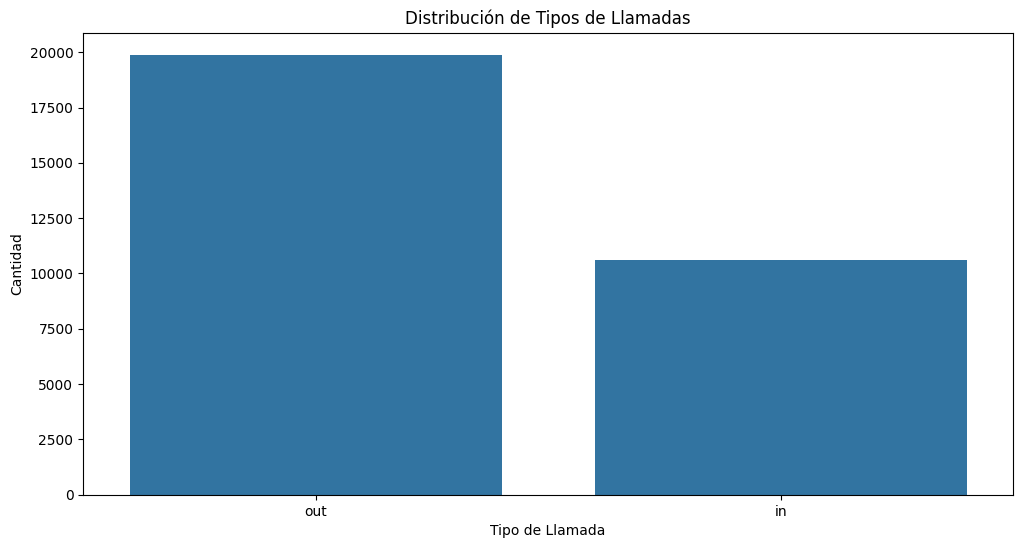

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='direction', data=df_calls)
plt.title('Distribución de Tipos de Llamadas')
plt.xlabel('Tipo de Llamada')
plt.ylabel('Cantidad')
plt.show()

# Métricas por operador

In [ ]:
operator_stats = df_calls.groupby('operator_id').agg(
    total_calls=('calls_count', 'sum'),
    missed_calls=('is_missed_call', lambda x: (x==True).sum()),
    total_call_duration=('call_duration', 'sum'),
    total_total_call_duration=('total_call_duration', 'sum'),
    incoming_calls=('direction', lambda x: (x=='in').sum()),
    outgoing_calls=('direction', lambda x: (x=='out').sum())
).reset_index()

operator_stats['missed_call_rate'] = operator_stats['missed_calls'] / operator_stats['total_calls']
operator_stats['avg_wait_time'] = (operator_stats['total_total_call_duration'] - operator_stats['total_call_duration']) / operator_stats['total_calls']

operator_stats.head()

,operator_id,total_calls,missed_calls,total_call_duration,total_total_call_duration,incoming_calls,outgoing_calls,missed_call_rate,avg_wait_time
0,879896.0,297,43,15323,20049,20,78,0.144781,15.912458
1,879898.0,349,29,9094,14946,56,40,0.083095,16.767908
2,880020.0,45,6,2245,2525,7,13,0.133333,6.222222
3,880022.0,194,29,12736,16506,8,61,0.149485,19.432990
4,880026.0,761,84,14300,26475,18,98,0.110381,15.998686


# Identificar operadores ineficaces

In [ ]:
ineffective_operators = operator_stats[
    (operator_stats['missed_call_rate'] > 0.30) |
    (operator_stats['avg_wait_time'] > 30)
]

print(f"Cantidad de operadores ineficaces detectados: {ineffective_operators.shape[0]}")

ineffective_operators.sort_values(by=['missed_call_rate', 'avg_wait_time'], ascending=False).head(10)

Cantidad de operadores ineficaces detectados: 155


,operator_id,total_calls,missed_calls,total_call_duration,total_total_call_duration,incoming_calls,outgoing_calls,missed_call_rate,avg_wait_time
602,932246.0,1,1,0,60,0,1,1.0,60.0
682,937770.0,1,1,0,37,0,1,1.0,37.0
159,899076.0,2,2,0,47,0,2,1.0,23.5
673,937716.0,1,1,0,19,0,1,1.0,19.0
685,937778.0,1,1,0,19,0,1,1.0,19.0
683,937772.0,1,1,0,18,0,1,1.0,18.0
700,937872.0,1,1,0,18,0,1,1.0,18.0
27,885682.0,3,3,0,51,0,3,1.0,17.0
1041,969262.0,1,1,0,17,0,1,1.0,17.0
672,937710.0,1,1,0,15,0,1,1.0,15.0


Para seleccionar operadores ineficaces, establecí algunas métricas o límites:
*   +30% llamadas perdidas o
*   30 segundos de espera promedio o más.

De esta manera detecté 155 operadores ineficaces.

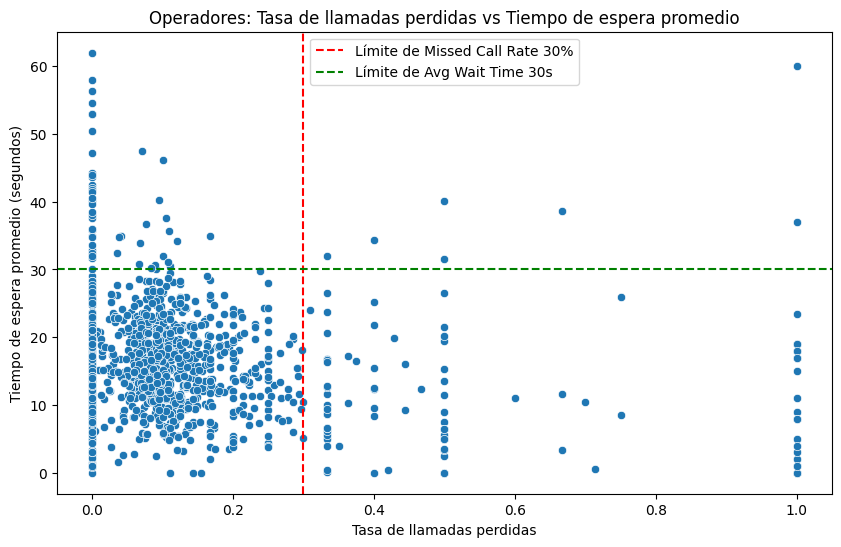

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=operator_stats, x='missed_call_rate', y='avg_wait_time')
plt.axvline(0.30, color='red', linestyle='--', label='Límite de Missed Call Rate 30%')
plt.axhline(30, color='green', linestyle='--', label='Límite de Avg Wait Time 30s')
plt.title('Operadores: Tasa de llamadas perdidas vs Tiempo de espera promedio')
plt.xlabel('Tasa de llamadas perdidas')
plt.ylabel('Tiempo de espera promedio (segundos)')
plt.legend()
plt.show()

# Pruebas de Hipótesis

*   H0: Los operadores ineficaces no tienen significativamente más llamadas perdidas que los eficaces.
*   HA: Los operadores ineficaces tienen significativamente más llamadas perdidas que los eficaces.



In [ ]:
alpha = 0.05

operator_stats['ineffective'] = operator_stats['operator_id'].isin(ineffective_operators['operator_id'])

group_effective = operator_stats[operator_stats['ineffective'] == False]['missed_call_rate']
group_ineffective = operator_stats[operator_stats['ineffective'] == True]['missed_call_rate']

stat, p_value = mannwhitneyu(group_effective, group_ineffective, alternative='less')  # "less" porque esperamos que los ineficaces tengan MÁS llamadas perdidas
print('Missed Call Rate - Prueba Mann-Whitney:')
print('Estadístico =', stat)
print('p-valor =', p_value)

if p_value <= alpha:
    print("Rechazamos la hipótesis nula. Los operadores ineficaces tienen significativamente más llamadas perdidas que los eficaces.")

else:
    print("No rechazamos la hipótesis nula. Los operadores ineficaces no tienen significativamente más llamadas perdidas que los eficaces.")

Missed Call Rate - Prueba Mann-Whitney:
Estadístico = 36660.0
p-valor = 2.514676792026596e-22
Rechazamos la hipótesis nula. Los operadores ineficaces tienen significativamente más llamadas perdidas que los eficaces.


*   H0: El tiempo de espera promedio no difiere significativamente entre operadores ineficaces y operadores eficaces.
*   HA: El tiempo de espera promedio difiere significativamente entre operadores ineficaces y operadores eficaces.



In [ ]:
group_effective = operator_stats[operator_stats['ineffective'] == False]['avg_wait_time']
group_ineffective = operator_stats[operator_stats['ineffective'] == True]['avg_wait_time']

stat, p_value = mannwhitneyu(group_effective, group_ineffective, alternative='two-sided')  # no sabemos dirección
print('\nAvg Wait Time - Prueba Mann-Whitney:')
print('Estadístico =', stat)
print('p-valor:', p_value)

if p_value <= alpha:
    print("Rechazamos la hipótesis nula. El tiempo de espera promedio difiere significativamente entre operadores ineficaces y operadores eficaces.")

else:
    print("No rechazamos la hipótesis nula. El tiempo de espera promedio no difiere significativamente entre operadores ineficaces y operadores eficaces.")


Avg Wait Time - Prueba Mann-Whitney:
Estadístico = 61909.0
p-valor: 0.012702690872942285
Rechazamos la hipótesis nula. El tiempo de espera promedio difiere significativamente entre operadores ineficaces y operadores eficaces.


*   H0: Los operadores ineficaces tienen la misma cantidad de llamadas promedio que los operadores eficaces.
*   HA: Los operadores ineficaces no tienen la misma cantidad de llamadas promedio que los operadores eficaces.



In [ ]:
group_effective = operator_stats[operator_stats['ineffective'] == False]['outgoing_calls']
group_ineffective = operator_stats[operator_stats['ineffective'] == True]['outgoing_calls']

stat, p_value = mannwhitneyu(group_effective, group_ineffective, alternative='two-sided')  # no sabemos dirección
print('\nOutgoing Calls - Prueba Mann-Whitney:')
print('Estadístico =', stat)
print('p-valor =', p_value)

if p_value <= alpha:
    print("Rechazamos la hipótesis nula. Los operadores ineficaces no tienen la misma cantidad de llamadas promedio que los operadores eficaces.")

else:
    print("No rechazamos la hipótesis nula. Los operadores ineficaces tienen la misma cantidad de llamadas promedio que los operadores eficaces.")


Outgoing Calls - Prueba Mann-Whitney:
Estadístico = 102774.5
p-valor = 1.3042303427339334e-19
Rechazamos la hipótesis nula. Los operadores ineficaces no tienen la misma cantidad de llamadas promedio que los operadores eficaces.


Se rechazó cada hipótesis nula debido a que sí se presentan diferencias significativas entre ambos grupos (Eficaces e ineficaces).



# Modelo para predecir la ineficiencia de un operador

In [ ]:
operator_stats.sample(5)

,operator_id,total_calls,missed_calls,total_call_duration,total_total_call_duration,incoming_calls,outgoing_calls,missed_call_rate,avg_wait_time,ineffective
504,923526.0,1052,61,38878,57000,44,75,0.057985,17.226236,False
114,894614.0,8,1,1467,1582,6,0,0.125000,14.375000,False
913,951506.0,194,13,13887,17002,17,36,0.067010,16.056701,False
194,901178.0,174,12,11291,12832,25,15,0.068966,8.856322,False
689,937788.0,474,24,20565,29158,27,46,0.050633,18.128692,False


In [ ]:
features = ['missed_call_rate', 'avg_wait_time', 'outgoing_calls']
X = operator_stats[features]
y = operator_stats['ineffective']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)


## Regresión logística

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model_lr = LogisticRegression(random_state=12345)
model_lr.fit(X_train, y_train)

LogisticRegression(random_state=12345)

In [ ]:
pred_lr = model_lr.predict(X_test)
proba_lr = model_lr.predict_proba(X_test)[:,1]

#Exactitud, precisión y recall
print('Exactitud: {:.2f}'.format(accuracy_score(y_test, pred_lr)))
print('Precisión: {:.2f}'.format(precision_score(y_test, pred_lr)))
print('Recall: {:.2f}'.format(recall_score(y_test, pred_lr)))

Exactitud: 0.97
Precisión: 0.95
Recall: 0.75


## Bosque aleatorio

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 50, max_depth=10, random_state = 12345)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=12345)

In [ ]:
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:,1]

# Exactitud, precisión y recall
print('Exactitud: {:.2f}'.format(accuracy_score(y_test, rf_pred)))
print('Precisión: {:.2f}'.format(precision_score(y_test, rf_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_pred)))

Exactitud: 1.00
Precisión: 0.96
Recall: 1.00


Probé con 2 modelos para predecir si un operador será eficaz o ineficaz, basándonos en sus características de desempeño.

Ambos modelos presentaron un desempeño muy adecuado en cuanto a Exactitud, precisión y Recall, pero Random Forest mostró mejor rendimiento general.

# Conclusiones y recomendaciones

Los operadores ineficaces presentan mayores tasas de llamadas perdidas, mayores tiempos de espera, y menor cantidad de llamadas salientes en comparación con los operadores eficaces.

Basándonos en los resultados del análisis realizado, recomendaría las siguientes acciones para optimizar el desempeño de los operadores en CallMeMaybe:

1. Identificar oportunidades de mejora o debilidades en cada operador considerado ineficiente.

2. Ofrecer programas de capacitación específicas para aquellas habilidades que necesitan reforzar.

3. Mantener un monitoreo activo en estos operadores para hacer seguimiento constante hasta que mejoren sus KPIs.

4. Ofrecer retroalimentación individual e implementar objetivos medibles a corto plazo.

5. Incorporar incentivos para motivar a los operadores a mejorar su rendimiento.

De esta manera, se espera tener menos llamadas perdidas, mejores tiempos de espera y duración de llamadas y más llamadas salientes.